In [166]:
import pandas as pd
import json
from datetime import datetime
import datetime import time

In [167]:
time_series_path = 'caltech/California_Garage_01/'

In [168]:
json_path = 'caltech/acndata_sessions.json'

with open(json_path, 'r') as f:
    json_data = json.load(f)

In [24]:
json_data['_items'][1]

{'_id': '5c412c1df9af8b12cb56c281',
 'clusterID': '0039',
 'connectionTime': 'Tue, 01 Jan 2019 21:08:49 GMT',
 'disconnectTime': 'Tue, 01 Jan 2019 22:52:39 GMT',
 'doneChargingTime': 'Tue, 01 Jan 2019 22:17:15 GMT',
 'kWhDelivered': 2.917,
 'sessionID': '2_39_139_28_2019-01-01 21:08:49.264929',
 'siteID': '0002',
 'spaceID': 'CA-303',
 'stationID': '2-39-139-28',
 'timezone': 'America/Los_Angeles',
 'userID': '000000838',
 'userInputs': [{'WhPerMile': 433,
   'kWhRequested': 25.98,
   'milesRequested': 60,
   'minutesAvailable': 277,
   'modifiedAt': 'Tue, 01 Jan 2019 21:08:55 GMT',
   'paymentRequired': True,
   'requestedDeparture': 'Wed, 02 Jan 2019 01:45:49 GMT',
   'userID': 838}]}

In [169]:
data['_items'][0]['userInputs'][0]

{'WhPerMile': 400,
 'kWhRequested': 20.0,
 'milesRequested': 50,
 'minutesAvailable': 282,
 'modifiedAt': 'Tue, 01 Jan 2019 21:06:08 GMT',
 'paymentRequired': True,
 'requestedDeparture': 'Wed, 02 Jan 2019 01:47:57 GMT',
 'userID': 1135}

In [170]:
time_series_session.keys()

Index(['Unnamed: 0', 'Charging Current (A)', 'Actual Pilot (A)', 'Voltage (V)',
       'Charging State', 'Energy Delivered (kWh)', 'Power (kW)'],
      dtype='object')

In [ ]:
X = []
Y = []
Z = []

for session in json_data['_items']:
    time_series_file = session['sessionID'].replace("_", "-" )
    time_series_file = time_series_file.replace(":", "-" )
    time_series_file = time_series_file.replace(".", "-" )
    time_series_file = time_series_file.replace(" ", "T" )
    
    try:
        kWhRequested = session['userInputs'][0]['kWhRequested']
        minutesAvailable = session['userInputs'][0]['minutesAvailable']
        modifiedAt = session['userInputs'][0]['modifiedAt']

        modifiedAt = datetime.strptime(modifiedAt[-12:-4], '%H:%M:%S')
        arrival = modifiedAt
        modifiedstart = arrival.replace(hour=0, minute=0, second=0)
        modifiedAt = abs(modifiedAt - modifiedstart).total_seconds() / 3600.0
        print(modifiedAt)
        
        milesRequested = session['userInputs'][0]['milesRequested']
        WhPerMile = session['userInputs'][0]['WhPerMile']
        userID = session['userInputs'][0]['userID']

        print(time_series_file)
        time_series_session = pd.read_csv(time_series_path + time_series_file + '.csv.gz', compression='gzip',
                   error_bad_lines=False)
            
        Y.append([kWhRequested, minutesAvailable, modifiedAt, milesRequested, WhPerMile, userID])
        X.append(time_series_session['Charging Current (A)'])
        Z.append(time_series_session['Actual Pilot (A)'])
        
    except:
        print("An exception occurred")

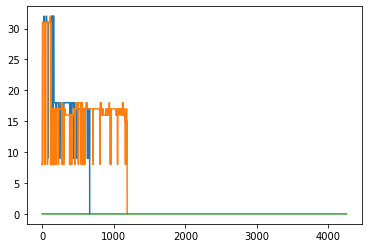

In [172]:
import matplotlib.pyplot as plt

plt.plot(Z[300])
plt.plot(Z[209])
plt.plot(Z[200])

In [181]:
len(Y)

10673

In [286]:
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from matrixprofile.distanceProfile import massDistanceProfile

In [134]:
charging_data = {}
charging_data['X'] = X
charging_data['Y'] = Y
charging_data['Z'] = Z

""" 
X:= Charging current time-series 
Z:= Pilot current time-series
Y:= Discrete charging data
""" 

In [135]:
# write python dict to a file
output = open('charging_data.pkl', 'wb')
pickle.dump(charging_data, output)
output.close()

In [136]:
# read python dict back from the file
pkl_file = open('charging_data.pkl', 'rb')
output = pickle.load(pkl_file)
pkl_file.close()

## Get Tails from X

In [332]:
def get_tails(X,Y):
    
    """ 
    X:= Charging current time-series 
    Y:= Discrete charging data
    """ 
    
    # Get user ID
    ID_list = []
    ID_dict = {}
    for session in range(len(Y)):
        ID_list.append(Y[session][5])
    ID_set = set(ID_list)
    
    for uid in ID_set:
        ID_dict[uid] = []
    
    for session in range(len(Y)):
        ID_dict[Y[session][5]].append(session) 
    
    # Consider user with more than 30 sessions
    sessions_per_user = 30
    selected_ID_list = []
    for k,v in ID_dict.items():
        if len(v) >= sessions_per_user:
            selected_ID_list.append(k)
            
    print(len(selected_ID_list))
    
    # Tail extraction parameters
    threshold = 10
    upbound = 15
    lowbound = 0
    duration = 80
    
    all_tails_list = []
    scaler = StandardScaler()
    
    for uid in selected_ID_list:
        
        df,bp = make_group(uid,X,ID_dict)
        scaled_current =  scaler.fit_transform(df[0].to_numpy().reshape(-1, 1))
        # Get a tail template 
        tail_start,tail_end,tail_template = get_template(df[0],bp,threshold,upbound,lowbound,duration)
        if tail_template == 0:
            continue
        else:
            m = len(tail_template)
            distance_profiles = massDistanceProfile(tail_template, 0, m, scaled_current.ravel())
            selected = choose_best(bp,distance_profiles)
            selected_strict = [i for i in selected if distance_profiles[0][i] < threshold]

        for tail in selected_strict:
            all_tails_list.append(tail)
    
    return all_tails_list

In [333]:
all_tails_list = get_tails(X,Y)

93
fails! no tail found


/Users/tonytiny/anaconda3/envs/neural/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


NameError: name 'mass' is not defined

In [325]:
X[0]

0       0.0
1       0.4
2       5.0
3       8.2
4       8.1
       ... 
4623    0.0
4624    0.0
4625    0.0
4626    0.0
4627    0.0
Name: Charging Current (A), Length: 4628, dtype: float64

In [204]:
def make_group(groupid,combined_df,users_dict):
    '''
    Group the time series with the same id into a single time series
    If resampled is true, then each time series will be resampled with a
    a same frequency before grouping (otherwise many redundant samples)
    
    The total number of series is len(list_of_bp)-1
    '''
    list_of_dfs = []
    list_of_bp = [0]
    num_row = 0
    for i in users_dict[groupid]:
        tmp = combined_df[i]
        list_of_dfs.append(tmp)
        num_row += len(tmp.index)
        list_of_bp.append(num_row)
    df = pd.concat(list_of_dfs)
    return df,list_of_bp

In [205]:
def choose_best(bp,distance_profiles):
    n = len(bp)-1
    indices = range(len(distance_profiles[0]))
    groups = [[] for i in range(n)]
    for idx in indices:
        tmp = [i for i, x in enumerate(bp[1:]) if idx<= x]
        groups[tmp[0]].append(idx)
    selected = []
    for group in groups:
        tmp_id = 0
        tmp_v = np.inf
        if len(group) > 0:
            for id in group:
                if distance_profiles[0][id] < tmp_v:
                    tmp_id = id
                    tmp_v = distance_profiles[0][id]
            selected.append(tmp_id)
    return selected

In [206]:
def extract_by_val(current_list,up=15,low=0):
    '''
    Extract the tails by specified values.
    :param current_list: a pd.Series of current readings with timestamp as index
    :param up: upper bound value
    :param low: lower bound value
    :return: an extracted current_list
    TODO: improve the function to be noise-robust
    Example:
        extract_by_val(current_list_jpl[34])
    '''
    tmp = [i for i, v in enumerate(list(current_list)) if v > up]
    if len(tmp) > 0:
        start_loc = tmp[-1]
    else:
        return 0,0
    tmp = [i for i, v in enumerate(list(current_list)) if (v <= low and i > start_loc)]
    if len(tmp)> 0:
        end_loc = tmp[0]
    else:
        return 0,0
    return start_loc,end_loc

In [304]:
def get_template(df,bp,threshold,upbound,lowbound=0,duration = 80,method='first'):
    # z-norm the whole current series
    scaler = StandardScaler()
    scaled_current =  scaler.fit_transform(df[0].to_numpy().reshape(-1, 1))
    # find the first valid tails
    tail_start = 0
    tail_end = 0
    if method =='first':
        i = 0
        while (tail_start == tail_end or (tail_end-tail_start)<duration) and i < (len(bp)-1):
            tail_start, tail_end = extract_by_val(df[0][bp[i]:bp[i+1]], upbound, lowbound)
            tail_start += bp[i]
            tail_end += bp[i]
            i += 1
        if i == (len(bp)-1):
            print("fails! no tail found")
            tail_template = 0
    tail_template = scaled_current.ravel()[tail_start:tail_end]
    return tail_start,tail_end,tail_template